# A Rigorous Machine Learning Pipeline (Supervised Binary Classification):
* Author: Ryan Urbanowicz, PhD 
*  Affiliation: University of Pennsylvania - Department of Biostatistics, Epidemiology, and Informatics & Institute for Biomedical Informatics (IBI) 
* Date: 8/25/20
***
## Introduction
This notebook presents an example of a 'rigorous' machine learning (ML) analysis pipeline that could be reasonablly applied to various supervised learning classification tasks. This pipeline was developed with biomedical data mining/modeling in mind. While this pipeline offers a comprehensive and rigorous proposed analysis, we do not suggest that this is necessarily the 'best' or 'only' way to conduct an appropriate binary classification ML analysis. 
***
## Environment Requirements
In order to run this pipeline as a Jupyter Notebook you must have the proper environment set up on your computer. Python 3 as well as a number of Python packages are required.  Most of these requirements are satisfied by installing the most recent version of anaconda (https://docs.anaconda.com/anaconda/install/). We used Anaconda3 with python version 3.7.7 during this pipeline development. In addition to the packages included in anaconda, the following packages will need to be installed separately (or possibly updated, if you have an older version installed):

* scikit-rebate (To install: pip install skrebate)
* xgboost (To install: pip install xgboost)
* lightgbm (To install: pip install lightgbm)
* optuna (To install: pip install optuna)

Additionally, while currently commented out in the file (modeling_methods.py) if you want the optuna hypterparameter sweep figures to appear within the jupyter notebook (via the command 'fig.show()' ) you will need to run the following installation commands.  This should only be required if you edit the python file to uncomment this line for any or all of the ML modeling algorithms. 

* pip install -U plotly>=4.0.0
* conda install -c plotly plotly-orca

Lastly, in order to include the stand-alone algorithm 'ExSTraCS' we needed to call this from the command line within this Jupyter Notebook.  As a result, the part of this notebook running ExSTraCS will only run properly if the path to the working directory used to run this notebook includes no spaces.  In other words if your path includes a folder called 'My Folder' vs. 'My_Folder' you will likely get a run error for ExSTraCS (at least on a Windows machine). Thus, make sure to check that wherever you are running this notebook from, that the entire path to the working directory does note include any spaces. 
***
## Dataset Requirements
This notebook loads a single dataset to be run through the entire pipeline. Here we summarize the requirements for this dataset:
* Ensure your data is in a single file: (If you have a pre-partitioned training/testing dataset, you should combine them into a single dataset before running this notebook)
* Any dataset specific cleaning, feature transformation, or feature engineering that may be needed in order to maximize ML performance should be conducted by the user separately or added to the beginning of this notebook. 
* The dataset should be in tab-delimited .txt format to run this notebook (as is).  Commented-out code to load a comma separated file (.csv) and excel file (.xlsx) is included in the notebook as an alternative. 
* Missing data values should be empty or indicated with an 'NA'.
* Dataset includes a header with column names. This should include a column for the binary class label and (optionally) a column for the instance ID, as well as columns for other 'features', e.g. independend variables. 
* The class labels should be 0 for the major class (i.e. the most frequent class), and 1 for the minor class.  This is important for generation of the precision/recall curve (PRC) plots. 
* This dataset is saved in the working directory containing the jupyter notebook file, and all other files in this repository.
* All variables in the dataset have been numerically encoded (otherwise additional data preprocessing may be needed)
***
## Notebook Organization
#### Part 1: Exploratory analysis, data cleaning, and creating n-fold CV partitioned datasets 
- Instances missing a class value are excluded
- The user can indicate other columns that should be excluded from the analysis
- The user can turn on/off the option to apply standard scaling to the data prior to CV partitioning or imputation
    - We use no scaling by default. This is because most methods should work properly without it, and in applying the model downstream, it is difficult to properly scale new data so that models may be re-applied later.
    - ANN modeling is sensitive to feature scaling, thus without it, performance not be as good. However this is only one of many challenges in getting ANN to perform well. 
- The user can turn on/off the option to impute missing values following CV partitioning
- The user can turn on/off the option for the code to automatically attempt to discriminate nominal from ordinal features
- The user can choose the number of CV partitions as well as the strategy for CV partitioning (i.e.  random (R), stratified (S), and matched (M) 
- CV training and testing datasets are saved as .txt files so that the same partitions may be analyzed external to this code
    
#### Part 2: Feature selection
- The user can turn on/off the option to filter out the lowest scoring features in the data (i.e. to conduct not just feature importance evaluation but feature selection)
- Feature importance evaluation and feature selection are conducted within each respective CV training partition
- The pipeline reports feature importance estimates via two feature selection algorithms:
    - Mutual Information: Proficient at detecting univariate associations
    - MultiSURF: Proficient at detecting univariate associations, 2-way epistatic interactions, and heterogeneous associations
    
- When selected by the user, feature selection conservatively keeps any feature identified as 'potentially relevant' (i.e. score > 0) by either algorithm
- Since MultiSURF scales quadratically with the number of training instances, there is an option to utilize a random subset of instances when running this algorithm to save computational time
    
#### Part 3: Machine learning modeling
- Seven ML modeling algorithms have been implemented in this pipeline:
    - Logistic Regression (scikit learn)
    - Decision Tree (scikit learn)
    - Random Forest (scikit learn)
    - Naïve Bayes (scikit learn)
    - XGBoost (separate python package)
    - LightGBM (separate python package)
    - SVM (scikit learn)
    - ANN (scikit learn)
    - ExSTraCS (v2.0.2.1) - a Learning Classifier System (LCS) algorithm manually configured to run in this notebook
- User can select any subset of these methods to run
- ML modeling is conducted within each respective CV training partition on the respective feature subset selected within the given CV partition
- ML modeling begins with a hyperparameter sweep conducted with a grid search of hard coded run parameter options (user can edit as needed)
- Balanced accuracy is applied as the evaluation metric for the hyperparameter sweep

#### Part 4: ML feature importance vizualization

***
## Schematic of ML Analysis Pipeline

<img src="ML pipeline schematic2.png" />

---
# Import Necessary Python Packages 

In [1]:
import pandas as pd
import numpy as np
import os
import random
import copy
import sys
import pickle
import time

from data_processing_methods import cv_partitioner
from data_processing_methods import identifyCategoricalFeatures
from data_processing_methods import imputeCVData
from data_processing_methods import dataScaling

from feature_selection_methods import reportAllFS
from feature_selection_methods import reportTopFS
from feature_selection_methods import sort_save_fi_scores
from feature_selection_methods import sort_save_fs_fi_scores
from feature_selection_methods import run_mi
from feature_selection_methods import run_multisurf
from feature_selection_methods import selectFeatures
from feature_selection_methods import genFilteredDatasets

from modeling_methods import classEval
from modeling_methods import roc_plot_single
from modeling_methods import save_performance
from modeling_methods import save_FI
from modeling_methods import eval_Algorithm_FI
from modeling_methods import eval_LCS
from modeling_methods import eval_LCS_QRF

#LCS package
#sys.path.append('C:/home/work/research_urbslab/Core_ML_Pipeline/ml_pipeline_lcs/exstracs_2.0.2.1_noclassmutate_lynch')
#import exstracs_main

#Statistics packages
from scipy import stats

#Visualization Packages:
#This code ensures that the output of plotting commands is displayed inline directly below the code cell that produced it.
%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
from matplotlib import rc
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import Progress bar:
from tqdm import tnrange, tqdm_notebook

---
# Set Dataset Pipeline Variables (Mandatory)
These variables values will have to be respecified to run this pipeline on a given dataset or computer

In [2]:
#Unique dataset name (include dataset extension) (must be updated for a given dataset analysis)
target_data = 'hcc-data_example.txt' 

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'Class Attribute' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = None #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = [] #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

---
# Set Other Pipeline Variables (Optional) 
These variables can be left as is, or modified to update key aspects of how the ML pipeline will be run and what methods will be included

In [3]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'S' #Options: random (R), stratified (S), matched (M)
matchName = None #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#ML Modeling -----------------------------------------------------------------------------------------------------
#To use all available algorithms, use the following (feel free to adjust the colors):
#algorithmsToRun = ['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'XGB', 'LGB','SVM','ANN','LCS','LCS_QRF'] 
#methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'Naïve Bayes','XGB','LGB', 'SVM', 'ANN','LCS','LCS_QRF')
#algColors = ['black','yellow','orange','grey','purple', 'aqua', 'red', 'pink', 'green', 'blue']

algorithmsToRun = ['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'XGB', 'LGB','SVM','ANN','LCS','LCS_QRF'] 
methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'Naïve Bayes','XGB','LGB', 'SVM', 'ANN','LCS','LCS_QRF')
algColors = ['black','yellow','orange','grey','purple', 'aqua', 'red', 'pink', 'green', 'blue']

#Note that the statistical comparisons and compound feature importance plot sections of this notebook will fail if only one modeling algorithm is selected here.
#To run a single ML modeling algorithm, use the following (example):
#algorithmsToRun = ['decision_tree'] 
#methodsKey = ('Decision Tree')
#algColors = ['black']

#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

## ML Modeling Hyperparamters (Optional)

In [4]:
#Optima Hyperparameter sweep run parameters
n_trials = 100 #number of bayesian hyperparameter optimization trials (using optuna)
scoring_metric = 'balanced_accuracy' #metric used to pick best hyperparamters
hype_cv = 3 #Internal cv partitions for hyperparamter sweep evaluations
timeout = 300 #Seconds until hyperparameter sweep stopped - 3600 sec = 1 hour, 300 sec = 5 min

#Logistic Regression
param_grid_LR = {'penalty' : ['l2','l1'],
                'C' : [1e-5, 1e5], 
                'dual' : [True, False],
                'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag','saga'],
                'class_weight' : [None, 'balanced'],
                'max_iter' : [10, 1000],
                'n_jobs' : [-1]}

#Decision Tree
param_grid_DT = {'criterion' : ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'class_weight' : [None, 'balanced']}

#Random Forest
param_grid_RF = {'n_estimators': [10,1000],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'bootstrap' : [True],
                'oob_score' : [False, True],
                'n_jobs' : [-1],
                'class_weight' : [None, 'balanced']}

#XG Boost - note: class weight balance is included as option internally
param_grid_XGB = {'booster': ['gbtree'],
                'objective' : ['binary:logistic'],
                'verbosity' : [0],
                'reg_lambda' : [1e-8, 1.0],
                'alpha' : [1e-8, 1.0],
                'eta' : [1e-8, 1.0],
                'gamma' : [1e-8, 1.0],
                'max_depth' : [1, 30],
                'grow_policy' : ['depthwise', 'lossguide'],
                'n_estimators': [10,1000],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'subsample' : [0.5, 1.0],
                'min_child_weight': [0.1, 10],
                'colsample_bytree': [0.1, 1.0]}

#LG Boost - note: class weight balance is included as option internally
param_grid_LGB = {'objective' : ['binary'],
                'metric': ['binary_logloss'],
                'verbosity' : [-1],
                'boosting_type': ['gbdt'],
                'num_leaves': [2,256],
                'max_depth' : [1, 30],
                'lambda_l1': [1e-8, 10.0],
                'lambda_l2': [1e-8, 10.0],
                'feature_fraction': [0.4, 1.0],
                'bagging_fraction': [0.4, 1.0],
                'bagging_freq': [1,7],
                'min_child_samples': [5,100],
                'n_estimators': [10,1000]}

#SVM
param_grid_SVM = {'kernel' : ['linear','poly','rbf'],
                'C': [0.1, 1000],
                'gamma': ['scale'],
                'degree': [1,6],
                'probability' : [True],
                'class_weight' : [None, 'balanced']}
        
#ANN
param_grid_ANN = {'n_layers' : [1,3],
                'layer_size' : [1,100],
                'activation': ['identity','logistic', 'tanh', 'relu'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'momentum': [.1,.9],
                'solver': ['sgd', 'adam'],
                'batch_size': ['auto'],
                'alpha': [0.0001, 0.05],
                'max_iter' : [200]}

param_grid = {} #stores all user selected algorithm hyperparameters

for algorithm in algorithmsToRun: #['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'xg_boost','SVM','ANN'] 
    if algorithm == 'logistic_regression':
        param_grid['logistic_regression'] = param_grid_LR
    elif algorithm == 'decision_tree':
        param_grid['decision_tree'] = param_grid_DT
    elif algorithm == 'random_forest':
        param_grid['random_forest'] = param_grid_RF
    elif algorithm == 'naive_bayes':
        pass #no hyperparameters
    elif algorithm == 'XGB':
        param_grid['XGB'] = param_grid_XGB
    elif algorithm == 'LGB':
        param_grid['LGB'] = param_grid_LGB
    elif algorithm == 'SVM':
        param_grid['SVM'] = param_grid_SVM
    elif algorithm == 'ANN':
        param_grid['ANN'] = param_grid_ANN
    elif algorithm =='LCS':
        pass #parameters are set directly
    elif algorithm =='LCS_QRF':
        pass #parameters are set directly
    else:
        print("Error: Algorithm not found!")

#LCS Hyperparameters (not set up for parameter sweep - uses specified and default hyperparameters)
lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch/exstracs_main.py' #LCS file to call
iterations = 20000
popsize = 1000
lcs_alg = 'ExSTraCS_2.0.2.1'

#Visualization ---------------------------------------------------------------------------------------------------
focus_metric = 'Balanced Accuracy'

#Statistical Significance-----------------------------------------------------------------------------------------
sig_cutoff = 0.05

---
# Notebook/Folder Initialization
For simplicity it is recommended that this not be altered.

In [5]:
#Standard Names (no need to change)
output_folder = 'results'
cv_data_folder = 'cv_datasets'
ua_folder = 'univariate'
model_folder = 'models'
lcs_folder = 'lcs'

#Working directory path automatically detected
wd_path = os.getcwd()
wd_path = wd_path.replace('\\','/')
wd_path = wd_path+'/'
print("Working Directory: "+wd_path)

#Save data name without extension for later file labeling
data_name = target_data.split('.')[0] 

#Create output folder if it doesn't already exist
if not os.path.exists(wd_path+(output_folder)):
    os.mkdir(wd_path+(output_folder))

#Create CV dataset folder if it doesn't already exist
if not os.path.exists(wd_path+(cv_data_folder)):
    os.mkdir(wd_path+(cv_data_folder))

#Create univariate analysis folder if it doesn't already exist
if not os.path.exists(wd_path+(ua_folder)):
    os.mkdir(wd_path+(ua_folder))
    
#Create model pickle folder if it doesn't already exist
if not os.path.exists(wd_path+(model_folder)):
    os.mkdir(wd_path+(model_folder))
    
#Create LCS output folder if it doesn't already exist
if not os.path.exists(wd_path+(lcs_folder)):
    os.mkdir(wd_path+(lcs_folder))

data_changed = False #Keeps track of whether cleaning changed original dataset (leave this set to False)

run_time_dict = {}
notebook_start_time = time.time()

Working Directory: C:/Users/Moore Lab/Desktop/ExSTraCS_ML_Pipeline_Binary_Notebook-master/


---
# Load Dataset
This code assumes that the data is being loaded as a tab delimited '.txt' file with columns as features/outcome, and rows as instances. It is also assumed that the target file includes a header and that missing values are indicated with 'NA' or an empty cell. This command can be updated depending on users dataset format. 

In [6]:
td = pd.read_csv(target_data, na_values='NA', sep = "\t") #Data load command for tab-delimited .txt file
#td = pd.read_csv(target_data, na_values='NA', sep = ",") #Data load command for comma-separated .csv file
#td = pd.read_excel(target_data) #Data load command for excel file

td.shape

(165, 50)

### Debugging data simplification (This code should be commented out during normal run)

In [7]:
#td = td.sample(frac=0.5, replace=False, random_state=randomSeed)

---
# Initial Exploratory Analysis

In [8]:
# Count the number of rows and columns
num_rows = td.shape[0]
print('Dataset contains '+str(num_rows)+' rows.')
num_cols = td.shape[1]
print('Dataset contains '+str(num_cols)+' columns.')

Dataset contains 165 rows.
Dataset contains 50 columns.


In [9]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender                            165 non-null    int64  
 1   Symptoms                          147 non-null    float64
 2   Alcohol                           165 non-null    int64  
 3   Hepatitis B Surface Antigen       148 non-null    float64
 4   Hepatitis B e Antigen             126 non-null    float64
 5   Hepatitis B Core Antibody         141 non-null    float64
 6   Hepatitis C Virus Antibody        156 non-null    float64
 7   Cirrhosis                         165 non-null    int64  
 8   Endemic Countries                 126 non-null    float64
 9   Smoking                           124 non-null    float64
 10  Diabetes                          162 non-null    float64
 11  Obesity                           155 non-null    float64
 12  Hemochro

In [10]:
td.describe()

,Gender,Symptoms,Alcohol,Hepatitis B Surface Antigen,Hepatitis B e Antigen,Hepatitis B Core Antibody,Hepatitis C Virus Antibody,Cirrhosis,Endemic Countries,Smoking,Diabetes,Obesity,Hemochromatosis,Arterial Hypertension,Chronic Renal Insufficiency,Human Immunodeficiency Virus,Nonalcoholic Steatohepatitis,Esophageal Varices,Splenomegaly,Portal Hypertension,Portal Vein Thrombosis,Liver Metastasis,Radiological Hallmark,Age at diagnosis,Grams of Alcohol per day,Packs of cigarets per year,Performance Status*,Encephalopathy degree*,Ascites degree*,International Normalised Ratio*,Alpha-Fetoprotein (ng/mL),Haemoglobin (g/dL),Mean Corpuscular Volume,Leukocytes(G/L),Platelets,Albumin (mg/dL),Total Bilirubin(mg/dL),Alanine transaminase (U/L),Aspartate transaminase (U/L),Gamma glutamyl transferase (U/L),Alkaline phosphatase (U/L),Total Proteins (g/dL),Creatinine (mg/dL),Number of Nodules,Major dimension of nodule (cm),Direct Bilirubin (mg/dL),Iron,Oxygen Saturation (%),Ferritin (ng/mL),Class Attribute
count,165.000000,147.000000,165.000000,148.000000,126.000000,141.000000,156.000000,165.000000,126.000000,124.000000,162.000000,155.000000,142.000000,162.000000,163.000000,151.000000,143.000000,113.000000,150.00000,154.000000,162.000000,161.000000,163.000000,165.000000,117.000000,112.000000,165.000000,164.000000,163.000000,161.000000,1.570000e+02,162.000000,162.000000,162.000000,162.000000,159.000000,160.000000,161.000000,162.000000,162.000000,162.000000,154.000000,158.000000,163.000000,145.000000,121.000000,86.000000,85.000000,85.000000,165.000000
mean,0.806061,0.639456,0.739394,0.108108,0.007937,0.269504,0.217949,0.903030,0.079365,0.508065,0.345679,0.129032,0.049296,0.364198,0.122699,0.019868,0.055944,0.610619,0.56000,0.714286,0.222222,0.223602,0.680982,64.690909,71.008547,20.464286,1.018182,1.158537,1.441718,1.421851,1.929995e+04,12.879012,95.119753,1473.961549,113206.442654,3.445535,3.087938,67.093168,96.382716,268.026543,212.211605,8.961039,1.127089,2.736196,6.851172,1.930000,85.598837,37.028941,438.997647,0.381818
std,0.396586,0.481800,0.440302,0.311571,0.089087,0.445284,0.414182,0.296817,0.271387,0.501963,0.477064,0.336322,0.217251,0.482697,0.329103,0.140009,0.230621,0.489782,0.49805,0.453228,0.417029,0.417959,0.467533,13.319534,76.277680,51.565130,1.181528,0.428137,0.685819,0.477816,1.490983e+05,2.145237,8.405846,2909.106006,107118.632481,0.685132,5.499379,57.539747,87.484241,258.750319,167.943548,11.728739,0.955856,1.797901,5.095042,4.210452,55.698995,28.993552,457.114454,0.487311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.840000,1.200000e+00,5.000000,69.500000,2.200000,1.710000,1.900000,0.300000,11.000000,17.000000,23.000000,1.280000,3.900000,0.200000,0.000000,1.500000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.170000,5.200000e+00,11.425000,89.775000,5.100000,255.750000,3.000000,0.800000,31.000000,46.250000,91.250000,108.250000,6.300000,0.700000,1.000000,3.000000,0.370000,40.500000,16.000000,84.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,66.000000,75.000000,0.000000,1.000000,1.000000,1.000000,1.300000,3.300000e+01,13.050000,94.950000,7.200000,93000.000000,3.400000,1.400000,50.000000,71.000000,179.500000,162.000000,7.050000,0.850000,2.000000,5.000000,0.700000,83.000000,27.000000,295.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000

In [11]:
td.dtypes

Gender                                int64
Symptoms                            float64
Alcohol                               int64
Hepatitis B Surface Antigen         float64
Hepatitis B e Antigen               float64
Hepatitis B Core Antibody           float64
Hepatitis C Virus Antibody          float64
Cirrhosis                             int64
Endemic Countries                   float64
Smoking                             float64
Diabetes                            float64
Obesity                             float64
Hemochromatosis                     float64
Arterial Hypertension               float64
Chronic Renal Insufficiency         float64
Human Immunodeficiency Virus        float64
Nonalcoholic Steatohepatitis        float64
Esophageal Varices                  float64
Splenomegaly                        float64
Portal Hypertension                 float64
Portal Vein Thrombosis              float64
Liver Metastasis                    float64
Radiological Hallmark           

In [12]:
td.nunique()

Gender                                2
Symptoms                              2
Alcohol                               2
Hepatitis B Surface Antigen           2
Hepatitis B e Antigen                 2
Hepatitis B Core Antibody             2
Hepatitis C Virus Antibody            2
Cirrhosis                             2
Endemic Countries                     2
Smoking                               2
Diabetes                              2
Obesity                               2
Hemochromatosis                       2
Arterial Hypertension                 2
Chronic Renal Insufficiency           2
Human Immunodeficiency Virus          2
Nonalcoholic Steatohepatitis          2
Esophageal Varices                    2
Splenomegaly                          2
Portal Hypertension                   2
Portal Vein Thrombosis                2
Liver Metastasis                      2
Radiological Hallmark                 2
Age at diagnosis                     51
Grams of Alcohol per day             19


### Assess Missingness in Columns

In [13]:
for i,c in enumerate(td.columns):
    na_percent = np.sum(td[c].isnull())/len(td)*100
    if na_percent > 0:
        print(c,'\t\t% Missing(N/A) = ',np.sum(td[c].isnull())/len(td)*100)

Symptoms  		% Missing(N/A) =  10.909090909090908
Hepatitis B Surface Antigen 		% Missing(N/A) =  10.303030303030303
Hepatitis B e Antigen 		% Missing(N/A) =  23.636363636363637
Hepatitis B Core Antibody 		% Missing(N/A) =  14.545454545454545
Hepatitis C Virus Antibody 		% Missing(N/A) =  5.454545454545454
Endemic Countries 		% Missing(N/A) =  23.636363636363637
Smoking 		% Missing(N/A) =  24.848484848484848
Diabetes 		% Missing(N/A) =  1.8181818181818181
Obesity 		% Missing(N/A) =  6.0606060606060606
Hemochromatosis 		% Missing(N/A) =  13.939393939393941
Arterial Hypertension 		% Missing(N/A) =  1.8181818181818181
Chronic Renal Insufficiency 		% Missing(N/A) =  1.2121212121212122
Human Immunodeficiency Virus 		% Missing(N/A) =  8.484848484848486
Nonalcoholic Steatohepatitis 		% Missing(N/A) =  13.333333333333334
Esophageal Varices 		% Missing(N/A) =  31.515151515151512
Splenomegaly 		% Missing(N/A) =  9.090909090909092
Portal Hypertension 		% Missing(N/A) =  6.666666666666667
Portal Ve

Text(0.5, 0, 'Missing Value Counts')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Missing Value Counts In Feature Set')

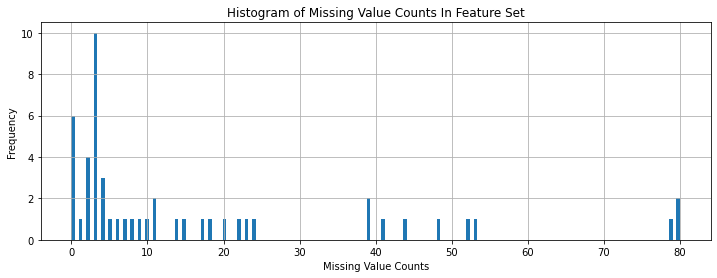

In [14]:
missing_count = td.isnull().sum()
#Plot a histogram of the missingness observed over all features in the dataset
ax = missing_count.hist(bins=num_rows,figsize=(12,4))
ax.set_xlabel("Missing Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Missing Value Counts In Feature Set")

---
# Data Cleaning

### Remove instances (rows) with missing outcome values

In [15]:
print("Number of training instances in original dataset = ",num_rows)
td = td.dropna(axis=0,how='any',subset=[outcomeLabel])
print("Number of training instances after removing instances with missing endpoint = ",len(td))
diff = num_rows-len(td)
print("Number of instances removed = ", diff)
num_rows = len(td) #reassign value (if changed)
if diff > 0:
    data_changed = True
td.shape

Number of training instances in original dataset =  165
Number of training instances after removing instances with missing endpoint =  165
Number of instances removed =  0


(165, 50)

In [16]:
#It's critical to reset the index after dropping rows to work with data frame later with pd.concat of separate columns
td = td.reset_index(drop=True)
td.shape
#Ensure Class variable is cast as an int
td[outcomeLabel] = td[outcomeLabel].astype(dtype='int64')
td.info()

(165, 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender                            165 non-null    int64  
 1   Symptoms                          147 non-null    float64
 2   Alcohol                           165 non-null    int64  
 3   Hepatitis B Surface Antigen       148 non-null    float64
 4   Hepatitis B e Antigen             126 non-null    float64
 5   Hepatitis B Core Antibody         141 non-null    float64
 6   Hepatitis C Virus Antibody        156 non-null    float64
 7   Cirrhosis                         165 non-null    int64  
 8   Endemic Countries                 126 non-null    float64
 9   Smoking                           124 non-null    float64
 10  Diabetes                          162 non-null    float64
 11  Obesity                           155 non-null    float64
 12  Hemochro

In [17]:
#Confirm no missing values in outcome variable
na_percent = np.sum(td[outcomeLabel].isnull())/len(td[outcomeLabel])*100
if na_percent > 0:
    print(c,'\t\t% Missing(N/A) = ',np.sum(td[outcomeLabel].isnull())/len(td)*100)
else:
    print('No missing values found in: '+ str(outcomeLabel))

No missing values found in: Class Attribute


### Remove columns to be ignored in analysis

In [18]:
print("Number of columns in original dataset = ", num_cols)
td = td.drop(ignore_columns, axis=1)
print("Number of columns after removing ignored columns = ", len(td.columns))
diff = num_cols-len(td.columns)
print("Number of columns removed = ", diff)
num_cols = len(td.columns)
if diff > 0:
    data_changed = True
td.shape

Number of columns in original dataset =  50
Number of columns after removing ignored columns =  50
Number of columns removed =  0


(165, 50)

### Assess class imbalance (assuming discrete outcome)

Counts of each class
0    102
1     63
Name: Class Attribute, dtype: int64


<AxesSubplot:>

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

(165, 50)

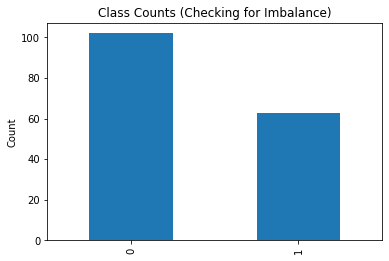

In [19]:
print("Counts of each class")
print(td[outcomeLabel].value_counts())
td[outcomeLabel].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
td.shape

### Identify categorical variables in dataset

In [20]:
if autoDetectCategorical:
    #Separate independent variables from the rest
    if instLabel == None or instLabel == 'None':
        x_data = td.drop([outcomeLabel], axis=1)
    else:
        x_data = td.drop([outcomeLabel,instLabel], axis=1)

    categorical_variables = identifyCategoricalFeatures(x_data,categoricalCutoff)
    #print(categorical_variables)
    td.shape

(165, 50)

---
# Example Code for other potential data cleaning/processing
- Not applied in this example script, but available here as an example

### Delete Rows/Instances with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [21]:
#num_rows = td.shape[0]
#print("Number of training instances in original dataset = ",num_rows)
#td = td.dropna()
#print("Number of training instances after removing instances with any missing values = ",td.shape[0])
#diff = num_rows-td.shape[0]
#if diff > 0:
#    data_changed = True

### Delete Columns with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [22]:
#num_cols = td.shape[1]
#print("Number of training instances in original dataset = ",num_cols)
#td = df.dropna(axis='columns')
#print("Number of training instances after removing instances with any missing values = ",td.shape[1])
#diff = num_cols-td.shape[1]
#if diff > 0:
#    data_changed = True

### One hot encoding of categorical variables
- Ensures that categorical variables are not treated in an ordinal manner by ML algorithms
- The code below is an example of how to convert a single column to one hot encoding, and is not meant to be run as is. 

In [23]:
## Example below assumes a data frame 'df' with a column called 'B'
#one_hot = pd.get_dummies(df['B'])
#df = df.drop('B',axis = 1)
#df = df.join(one_hot)

### Other possible cleaning steps:
- encode text values as numerics
- oversample or undersample to reduce class imbalance
- drop additional rows based on assigned cutoffs, etc
- cast variable types as nominal or ordinal
- construct missingness features with MissingIndicator: https://scikit-learn.org/stable/modules/impute.html

In [24]:
#Saved for later, determines if imputation attempted.
isMissingData = False
if td.isnull().values.any():
    isMissingData = True

## Save cleaned dataset if it has been modified

In [ ]:
if data_changed:
    print('Saving cleaned data.')
    td.shape
    data_name = data_name +'_clean'
    td.to_csv(data_name+'.txt', index=None, sep='\t')

---
# Further Exploratory/Descriptive Analysis
- Visualize feature correlations in data
- Appropriate univariate analyses

## Feature Correlations

In [ ]:
if doCorrelation:
    #Drop outcome column for correlation analysis
    td_cor = td.drop([outcomeLabel], axis=1)
    
    #Compute correlation between the outcome and each feature , excluding NA/null values.
    corrmat = td_cor.corr(method='pearson') 
    f, ax = plt.subplots(figsize = (40,20)) # Note: need large size
    sns.heatmap(corrmat, vmax =1.0,square = True) # Set max value and square-shaped


## Univariate Analysis and Plots
Below we have encoded a method to automatically select an appropriate plot and univariate association test between a single feature and the target outcome in the dataset.

In [ ]:
# Code to analyze the univariate relationship between the outcome and each feature
def test_selector(featureName, outcomeLabel, td, categorical_variables):
    p_val = 0
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        
        #Univariate association test (Chi Square Test of Independence - Non-parametric)
        c, p, dof, expected = scs.chi2_contingency(table)
        p_val = p
        
    #Feature is continuous and Outcome is discrete/categorical/binary
    else: 
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=td[featureName].loc[td[outcomeLabel] == 0],y=td[featureName].loc[td[outcomeLabel] == 1])
        p_val = p
        
    return p_val

In [ ]:
# Function select appropriate visualizations to examine univariate relationships between each feature and outcome

def graph_selector(featureName, outcomeLabel, td, categorical_variables):
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Generate contingency table count bar plot. ------------------------------------------------------------------------
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        geom_bar_data = pd.DataFrame(table)
        mygraph = geom_bar_data.plot(kind='bar')
        plt.ylabel('Count')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Barplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight",format='png')
        plt.show()
        
    #Feature is continuous and Outcome is discrete/categorical/binary    
    else: 
        #Generate boxplot-----------------------------------------------------------------------------------------------------
        mygraph = td.boxplot(column=featureName,by=outcomeLabel)
        plt.ylabel(featureName)
        plt.title('')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Boxplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight",format='png')
        plt.show()

In [ ]:
if doUA:
    p_val_dict = {}
    # run appropriate univariate association test for each independent variable
    for each in td:
        if each != outcomeLabel and each != instLabel: 
            p_val_dict[each] = test_selector(each, outcomeLabel, td, categorical_variables)
    
    num_features = td.shape[1] - 1
    
    sorted_p_list = sorted(p_val_dict.items(), key = lambda item:item[1])
    
    #Save all p-values to file
    pval_df = pd.DataFrame.from_dict(p_val_dict, orient='index')
    filepath = wd_path+ua_folder+'/'+'UA_Significance_'+data_name+'.csv'
    pval_df.to_csv(filepath, header=['p-value'], index=True)  
    
    min_num = min(topResults,num_features)
    sorted_p_list = sorted_p_list[: min_num]
    print('Plotting top significant '+ str(min_num) + ' features.')
    
    # summarize significant values of selected number of features
    print('###################################################')
    print('Significant Univariate Associations:')
    for each in sorted_p_list[:min_num]:
        print(each[0]+": (p-val = "+str(each[1]) +")")

    #generate appropriate descriptive plot for selected number of features
    for i in sorted_p_list:
        for j in td:
            if j == i[0]:# if the feature name is within the selected feature list
                graph_selector(j, outcomeLabel, td, categorical_variables) #plot appropriate figure for each feature

---
# Create n-fold Cross Validation (CV) Datasets 
- i.e. Training and Testing Datasets

In [ ]:
#Create a header list of independant feature names
header = td.columns.values.tolist()
header.remove(outcomeLabel)
if instLabel != None and instLabel != 'None':
    header.remove(instLabel)

#Perform CV partitioning (get back list of training and testing partition dataframes)
train_dfs, test_dfs = cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed)

if partition_method == 'M':
    header.remove(matchName)

---
# Transform data - Standard Scaling
- Features are independently scaled to allow them to be more comparable in downstream logistic regression modeling, etc
- Scaling is learned on the training data and saved with pickel so that the same scaling may be applied to any future testing data
- Completed within each training and testing partition independently

In [ ]:
if scaleData:
    print('Scaling Data')
    data_name = data_name +'_scale'
    name_path = wd_path+model_folder+'/'+'Scalar_' + data_name+'_'
    train_dfs, test_dfs = dataScaling(train_dfs, test_dfs, outcomeLabel, instLabel, name_path, header)

---
# Impute Missing Data Values
- Missing data values in categorical features are imputed with simple 'mode' imputation
- Remaining missing data values are imputed using Iterative Imputer (i.e. MICE) 
- Completed within each training and testing partition independently

In [ ]:
if imputeData and isMissingData:
    print('Imputing Data')
    data_name = data_name + '_imp'
    train_dfs, test_dfs = imputeCVData(outcomeLabel, instLabel, categorical_variables, header, train_dfs, test_dfs, randomSeed)

### Confirm Missing Data Imputation

In [ ]:
print("Training Datasets")
for each in train_dfs:
    each.isnull().sum().sum()

print("Testing Datasets")
for each in test_dfs:
    each.isnull().sum().sum()

## Save Training and Testing Datasets as .txt Files

In [ ]:
data_name = data_name+'_CV_'+str(partition_method)

counter = 0
for each in train_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Train.txt', index=None, sep='\t')
    counter += 1
    
counter = 0
for each in test_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Test.txt', index=None, sep='\t')
    counter += 1

---
# Load, Check, and Prepare Saved CV Datasets for ML

## Load CV Partition Datasets
Re-loads training and testing datasets from saved .txt files

In [ ]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt', na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt', na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Testing Partitions: '+ str(len(testList)))

#### Quality Control Check (Checking one of the partitions)
Merge the first training/testing datasets to confirm original dataset is reconstituted

In [ ]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print("Number of Cases in Original Dataset: "+str(casesTrain+casesTest))
print("Number of Controls in Original Dataset: "+str(controlsTrain+controlsTest))

In [ ]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))
numColumns = trainList[0].shape[1]

## Partition Data Preprocessing
If present, remove instance id's from datasets prior to analysis. Also confirm that training and testing sets have same set of columns.

In [ ]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [ ]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

if not trainColumnNames == testColumnNames:
    print('Error: Training columns do not match testing columns!')

# As we can see, instLabel is no longer a column name for any of the sets
#print(trainColumnNames)
#print(testColumnNames)

#Create master list of feature names (excluding outcome column)
ordered_feature_names = copy.deepcopy(trainColumnNames) #Stores original ordered feature list 
ordered_feature_names.remove(outcomeLabel)
#ordered_feature_names

## Format data for Scikit learn (separate features from outcome)

In [ ]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)

---
# Feature Importance Evaluation
- Completed independently within each training dataset

In [ ]:
#Store indexes of 'interesting' features identified by each algorithm in algorithm labeled dictionary
selectedFeatureLists = {}
metaScoreDict = {}
metaFeatureRanks = {}

## Mutual information

In [ ]:
#Run Mutual Information for each CV------------------------------------------------------------------------------
algorithm = 'mutual_information'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    featureNameRanks = [] #list of feature name ranks for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_mi(xTrainList[i],yTrainList[i], i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    #cv_output_name = data_name+'_clean_imp_CV_'+partition_method
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('Mutual Information Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## MultiSURF

In [ ]:

#Run MultiSURF for each CV------------------------------------------------------------------------------
algorithm = 'multisurf'
if algorithm in algorithms:
    start_time = time.time()
    
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #If training set is large MultiSURF will run very slowly - quadradic time complexity with # instances (so use subset)
        tempData = pd.concat([pd.DataFrame(yTrainList[i]),pd.DataFrame(xTrainList[i])], axis=1, sort=False)
        if len(tempData) < instanceSubset:
            dataSample = tempData.sample(n=len(tempData), axis = 0)
        else:
            dataSample = tempData.sample(n=instanceSubset, axis = 0)

        xTrain = dataSample.iloc[:, 1:].values
        yTrain = dataSample.iloc[:, 0].values
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_multisurf(xTrain,yTrain, i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('MultiSURF Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

---
# Feature Selection

## Identify union of 'interesting' features from different algorithms
- Operates no matter how many feature selection methods are being applied
- But assumes that all methods have larger scores as being more informative

In [ ]:
cv_Selected_List = selectFeatures(algorithms, cv_partitions, selectedFeatureLists, maxFeaturesToKeep,metaFeatureRanks)

### Report counts of 'interesting' features identified by each algorithm

In [ ]:
print('Original feature count: '+str(len(ordered_feature_names)))

for each in algorithms:
    print(each)
    for cv in selectedFeatureLists[each]:
        print(len(cv))
    
print("Selected Counts")
for each in cv_Selected_List:
    print(len(each))

## Generate Filtered Datasets (Save as new .txt files)
- These datasets included only the selected features for each respective partition
- Note that the feature order from the original datasets is no longer preserved in these datasets

In [ ]:
if filterPoorFeatures:
    genFilteredDatasets(cv_Selected_List, outcomeLabel, instLabel,cv_partitions,cv_data_folder,data_name)
    data_name = data_name +'_FS'

## Generate Filtered MultiSURF Files (Save as new .txt files)

In [ ]:
if 'multisurf' in algorithms: #This method is only meant for working with MultiSURF scores
    if filterPoorFeatures:
        for i in range(cv_partitions):
            tempDict = scoreDictSet[i]

            #create new dictionary with only selected features
            scoreDict = {}
            for j in cv_Selected_List[i]:
                scoreDict[j] = tempDict[j]
            
            filename = output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
            sort_save_fs_fi_scores(scoreDict, 'multisurf', filename)

---
# Load, Check, and Prepare Filtered CV Datasets for ML
- If user opted not to filter datasets then the code below will simply reload the original CV datasets again.

## Load CV Partition Datasets (Filtered Datasets)

In [ ]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)

    #Load testing partition
    testset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Testing Partitions: '+ str(len(testList)))

## CV partition data cleaning (Filtered Datasets)

In [ ]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [ ]:
global_ordered_features = [] #Holds the new order of features in the FS CV datasets
for i in range(cv_partitions):
    cv_ordered_features = list(trainList[i])
    cv_ordered_features.remove(outcomeLabel)
    #print(cv_ordered_features)
    global_ordered_features.append(cv_ordered_features)

## Format data for Scikit learn (filtered datasets)

In [ ]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


---
# Machine Learning Modeling
ML algorithms are run one after the other below. Within each we conduct a hyperparameter sweep, train a best model and evaluate it indendently within each CV training/testing partition. 
- All standard classification metrics are computed for the resulting models as well as an ROC curve and precision/recall curve

## Run Logistic Regression

In [ ]:
algorithm = 'logistic_regression'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Logistic Regression Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Decision Tree

In [ ]:
algorithm = 'decision_tree'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Decision Tree Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Random Forest

In [ ]:
algorithm = 'random_forest'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Random Forest Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Naive Bayes

In [ ]:
algorithm = 'naive_bayes'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Naive Bayes Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run XGBoost

In [ ]:
algorithm = 'XGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('XGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LGBoost

In [ ]:
algorithm = 'LGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
        
    elapsed_time = time.time() - start_time
    print('LGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run SVM

In [ ]:
algorithm = 'SVM'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('SVM Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ANN

In [ ]:
algorithm = 'ANN'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('ANN Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LCS

In [ ]:
def makeConfigFile(train_dataset,test_dataset,outpath,external_ek_file,iterations,popsize,configfile,outcomelabel,instancelabel,discthresh):
    """ Construct Configuration File for CV Analysis """
    configFile = open(configfile,'w')
    
    #Write to Config File#############################################################################################################
    configFile.write('offlineData=1# \n')
    configFile.write('trainFile='+str(train_dataset)+'# \n')
    configFile.write('testFile='+str(test_dataset)+'# \n')
    configFile.write('internalCrossValidation=0# \n')
    
    configFile.write('outFileName='+str(outpath)+'# \n')
    configFile.write('randomSeed=1# \n')
    configFile.write('labelInstanceID='+str(instancelabel)+'# \n')
    configFile.write('labelPhenotype='+str(outcomelabel)+'# \n')
    configFile.write('discreteAttributeLimit='+str(discthresh)+'# \n')
    configFile.write('labelMissingData=NA# \n')
    configFile.write('outputSummary=1# \n')
    configFile.write('outputPopulation=1# \n')
    configFile.write('outputAttCoOccur=1# \n')
    configFile.write('outputTestPredictions=1# \n')  
    configFile.write('maxAttsCoOccur=50# \n')
        
    configFile.write('trackingFrequency=0# \n')
    configFile.write('learningIterations='+str(iterations)+'# \n')
    
    configFile.write('N='+str(popsize)+'# \n') 
    configFile.write('nu=1# \n')
    configFile.write('chi=0.8# \n')
    configFile.write('upsilon=0.04# \n')
    configFile.write('theta_GA=25# \n')
    configFile.write('theta_del=20# \n')   
    configFile.write('theta_sub=20# \n')    
    configFile.write('acc_sub=0.99# \n')    
    configFile.write('beta=0.2# \n')         
    configFile.write('delta=0.1# \n')     
    configFile.write('init_fit=0.01# \n')
    configFile.write('fitnessReduction=0.1# \n')
    configFile.write('theta_sel=0.5# \n')
    configFile.write('RSL_Override=0# \n')

    configFile.write('doSubsumption=1# \n')
    configFile.write('selectionMethod=tournament# \n')
    
    configFile.write('doAttributeTracking=1# \n')
    configFile.write('doAttributeFeedback=1# \n')
    
    configFile.write('useExpertKnowledge=1# \n')
    configFile.write('external_EK_Generation='+str(external_ek_file)+'# \n')
    configFile.write('outEKFileName=None# \n')
    
    configFile.write('filterAlgorithm=None# \n')
    configFile.write('turfPercent=0.2# \n')
    configFile.write('reliefNeighbors=10# \n')
    configFile.write('reliefSampleFraction=1# \n')
    configFile.write('onlyEKScores=0# \n')
    
    configFile.write('doRuleCompaction=1# \n')
    configFile.write('onlyRC=0# \n')
    configFile.write('ruleCompactionMethod=QRF# \n')
    
    configFile.write('doPopulationReboot=0# \n')
    configFile.write('popRebootIteration=0# \n')
    
    configFile.close()

### Generate LCS Configuration Files (needed to pass all run/hyperparamters)

In [ ]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    # Generate LCS configuration files (needed to pass all run/hyper parameters to LCS)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        trainFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
        testFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
        ekFile = wd_path+output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
        configfile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        outFold = wd_path+lcs_folder+'/'

        makeConfigFile(trainFile,testFile,outFold,ekFile,iterations,popsize,configfile,outcomeLabel,instLabel,categoricalCutoff)

In [ ]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    #Use Python Magic to run Exstracs from command line
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch'+'/'+'exstracs_main.py'
        configFile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        %run {lcs_path} {configFile}

### Load and Evaluate LCS Predictions

In [ ]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    elapsed_time = time.time() - start_time
    print('LCS Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

### Load and Evaluate LCS with QRF Predictions

In [ ]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS_QRF(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

### Load and Evaluate LCS Feature Importance Estimates

In [ ]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

### Load and Evaluate LCS with QRF Feature Importance Estimates

In [ ]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_RC_QRF_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

---
# Review result table (for global ROC and PRC figure building)

In [ ]:
#Load pickle files of results
result_table = []

for algorithm in algorithmsToRun:
    tempDict = pickle.load(open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'rb'))
    result_table.append(tempDict)
    
result_table = pd.DataFrame.from_dict(result_table)

In [ ]:
result_table
result_table.set_index('algorithm', inplace=True)

---
# ROC Plot Summarizing Analysis

In [ ]:
#Multi-algorithm ROC plot
fig = plt.figure(figsize=(8,8))
count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], color = algColors[count],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    count += 1
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_ROC_' + data_name), bbox_inches = "tight")
plt.show()


---
# PRC Plot Summarizing Analysis

In [ ]:
#Multi-algorithm PRC plot ['algorithm','fpr','tpr','auc','prec','pr_auc','ave_prec'])
#result_table.set_index('algorithm', inplace=True)

fig = plt.figure(figsize=(8,8))

count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['prec'], color = algColors[count],
             label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
    count += 1
noskill = len(yTestList[0][yTestList[0]==1]) / len(yTestList[0]) #Fraction of cases
plt.plot([0,1], [noskill,noskill], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_PRC_' + data_name), bbox_inches = "tight")
plt.show()


---
# Summarize Algorithm Metrics 

In [ ]:
td = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_Metrics_'+data_name+'.csv')
metrics = list(td.columns.values.tolist()) 

metric_summary = pd.DataFrame(index=metrics,columns=algorithmsToRun)
master_list = []

for algorithm in algorithmsToRun:
    #Open file
    td = pd.read_csv(wd_path+output_folder+'/'+algorithm+'_Metrics_'+data_name+'.csv')
    master_list.append(td)
    for metric in metrics:
        ave = td[metric].mean()
        sd = td[metric].std()
        metric_summary.at[metric, algorithm] = str(round(ave,4))+' ('+str(round(sd,4))+')'
    
metric_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_Metrics_'+data_name+'.csv')   

In [ ]:
metric_summary

---
# Performance Metric Boxplots Comparing Algorithms

In [ ]:

#For each metric
for metric in metrics:
    i = 0
    tempList = []
    for algorithm in algorithmsToRun:
        temp_td = master_list[i]
        tempList.append(temp_td[metric].tolist())
        i += 1
        
    td = pd.DataFrame(tempList)
    td = td.transpose()
    td.columns = algorithmsToRun
        
    boxplot = td.boxplot(column=algorithmsToRun,rot=45)
    plt.title('Comparing Algorithm '+ str(metric))
    plt.ylabel(str(metric))
    plt.xlabel('ML Algorithm')
    plt.savefig((wd_path+output_folder+'/'+'Compare_'+str(metric)+'_Boxplot_'+data_name), bbox_inches = "tight")
    plt.show()


---
# Statistical Comparisons
- Kruskal Wallis AOV comparing ML algorithms
- Mann-Whitney U test - Pairwise algorithm differences  

## Kruskal Wallis Test - Algorithm comparisons for each metric
- Are any algorithms performing statistically better or worse? 

## Mann-Whiney Test - Pairwise Post-Hoc Analysis 
- For any metric where kruskal wallis test was significant.

In [ ]:
if len(algorithmsToRun) > 1:
    label = ['statistic','pvalue','sig']
    kruskal_summary = pd.DataFrame(index=metrics,columns=label)
    for metric in metrics:
        tempArray = []
        for i in range(len(algorithmsToRun)):
            tempArray.append(master_list[i][metric])
        result = stats.kruskal(*tempArray)
        #result = stats.kruskal(master_list[0][metric],master_list[1][metric],master_list[2][metric],master_list[3][metric],master_list[4][metric],master_list[5][metric],master_list[6][metric]) 
        kruskal_summary.at[metric, 'statistic'] = str(round(result[0],6))
        kruskal_summary.at[metric, 'pvalue'] = str(round(result[1],6))
        if result[1] < sig_cutoff:
            kruskal_summary.at[metric, 'sig'] = str('*')
        else:
            kruskal_summary.at[metric, 'sig'] = str('')

    kruskal_summary

    kruskal_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_KruskalWallis_'+data_name+'.csv')   

In [ ]:
if len(algorithmsToRun) > 1:
    algCount = len(algorithmsToRun)
    for metric in metrics:
        if kruskal_summary['sig'][metric] == '*':
            mann_stats = []
            #Balanced Accuracy
            for i in range(0,algCount-1):
                for j in range(i+1,algCount):
                    set1 = master_list[i][metric]
                    set2 = master_list[j][metric]

                    #print('Mann-WhitneyU: '+str(algorithmsToRun[i])+' vs. '+str(algorithmsToRun[j]))
                    report = stats.mannwhitneyu(set1,set2)
                    #report
                    tempstats = [algorithmsToRun[i], algorithmsToRun[j], report[0], report[1], '']
                    if report[1] < sig_cutoff:
                        tempstats[4] = '*'
                    mann_stats.append(tempstats)

            mann_stats_df = pd.DataFrame(mann_stats)
            mann_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'statistic', 'p-value', 'sig']
            filepath = wd_path+output_folder+'/'+'MannWhitney_'+str(metric)+'_'+data_name+'.csv'
            mann_stats_df.to_csv(filepath, index = False) 
            mann_stats_df

---
# Visualize Feature Importance Results Across Algorithms

## Specify dataset specific paths/names

In [ ]:
figx = 24
figy = 12
    
#Feature names to use in the final publication figures
df = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_FI_'+data_name+'.csv')

printfeatureNames = list(df.columns)
print(printfeatureNames)

## Load feature importance and balanced accuracy results
- Do this generically so that future algorithms can be added here
- Identify a feature list for each algorithm (only features with average scores over zero)
- Identify union of these feature lists - master feature list to be included in bar chart
- Have a max_features to visualize - use ranking to reduce above list as needed to top n features only.
- Add ability to load LCS or other external algorithm to these results

In [ ]:
#algorithm feature importance dataframe list (used to generate FI boxplots for each algorithm)
fi_df_list = []
#algorithm feature importance averages list (used to generate composite FI barplots)
fi_ave_list = []
#algorithm focus metric averages list (used in weighted FI viz)
ave_metric_list = []
#list of pre-feature selection features as they appear in FI reports for each algorithm
all_feature_list = []

In [ ]:
for each in algorithmsToRun:
    #Get relevant feature importance info
    temp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_FI_'+data_name+'.csv')
    if each == algorithmsToRun[0]: #Should be same for all algorithm files (i.e. all original features in standard CV dataset order)
        all_feature_list = temp_df.columns.tolist()
    fi_df_list.append(temp_df) 
    fi_ave_list.append(temp_df.mean().tolist())
    
    #Get relevant metric info
    tmp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_Metrics_'+data_name+'.csv')
    ave_metric_list.append(tmp_df[focus_metric].mean())
ave_metric_list

### Normalize average scores (Range 0-1)

In [ ]:
#Normalize average scores so all values range between 0 and 1 (important for combining FI's)
fi_ave_norm_list = []
for each in fi_ave_list: #each algorithm   
    normList = []
    for i in range(len(each)):
        if each[i] <= 0:
            normList.append(0)
        else:
            normList.append((each[i])/(max(each)))
    fi_ave_norm_list.append(normList)


### Identify features with non-zero averages

In [ ]:
# For each algorithm identify all non-zero features
alg_non_zero_FI_list = []
for each in fi_ave_list: #each algorithm
    
    temp_non_zero_list = []
    for i in range(len(each)): #each feature
        if each[i] > 0.0:
            temp_non_zero_list.append(all_feature_list[i])
    
    alg_non_zero_FI_list.append(temp_non_zero_list)

### Identify union of features with non-zero averages over all algorithms

In [ ]:
#Identify a union list over all algorithms of features with non-zero FI (These are candidates for vizualization)
non_zero_union_features = alg_non_zero_FI_list[0] #grab first algorithm's list

for j in range(1,len(algorithmsToRun)):
    #print(j)
    non_zero_union_features = list(set(non_zero_union_features) | set(alg_non_zero_FI_list[j]))

#print(non_zero_union_features)

non_zero_union_indexes = []
for i in non_zero_union_features:
    non_zero_union_indexes.append(all_feature_list.index(i))
non_zero_union_indexes

### Identify list of top features over all algorithms to visualize

In [ ]:
#If remaining non-zero feature list is still larger than we want to visualize, pick only top features for visualization
featuresToViz = None
if len(non_zero_union_features) > topResults:
    #Identify a top set of feature values
    scoreSumDict = {}
    i = 0
    for each in non_zero_union_features: #for each non-zero feature
        for j in range(len(algorithmsToRun)): #for each algorithm
            #grab target score from each algorithm
            score = fi_ave_norm_list[j][non_zero_union_indexes[i]]
            #multiply score by algorithm performance weight
            score = score*ave_metric_list[j]
            if not each in scoreSumDict:
                scoreSumDict[each] = score
            else:
                scoreSumDict[each] += score
        i += 1
        
    for each in scoreSumDict:
        scoreSumDict[each] = scoreSumDict[each]/ len(algorithmsToRun)
    #print(scoreSumDict)

    #Rank and select top features to visualize

    #Sort features by decreasing score
    scoreSumDict_features = sorted(scoreSumDict, key=lambda x: scoreSumDict[x], reverse=True)
    #scoreSumDict_features

    featuresToViz = scoreSumDict_features[0:topResults]
    #featuresToViz
else:
    featuresToViz = non_zero_union_features #Ranked feature name order

## Generate individual feature importance boxplots for each algorithm

In [ ]:
counter = 0
for df in fi_df_list:
    fig = plt.figure(figsize=(15,4))
    boxplot = df.boxplot(rot=90)
    plt.title(algorithmsToRun[counter])
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.xticks(np.arange(1,len(printfeatureNames)+1), printfeatureNames,rotation='vertical')
    plt.savefig((wd_path+output_folder+'/'+algorithmsToRun[counter]+'_boxplot_' + data_name), bbox_inches = "tight")
    plt.show()

    counter += 1

### Create Normalized dataframes with feature viz subsets

In [ ]:
featuresToViz

feature_indexToViz = []
for i in featuresToViz:
    feature_indexToViz.append(all_feature_list.index(i))
feature_indexToViz

#Preserve features in original dataset order for consistency
top_fi_ave_norm_list = []
for i in range(len(algorithmsToRun)):
    tempList = []
    for j in range(len(fi_ave_norm_list[i])):
        if j in feature_indexToViz:
            tempList.append(fi_ave_norm_list[i][j])
    top_fi_ave_norm_list.append(tempList)

#Create feature name list in propper order
all_feature_listToViz = []
for j in (all_feature_list):
    if j in featuresToViz:
        all_feature_listToViz.append(j)
all_feature_listToViz

In [ ]:
def compound_FI_plot(fi_list,algorithmsToRun,algColors,all_feature_listToViz,figName):
    
    # y-axis in bold
    rc('font', weight='bold', size=16)
    
    # The position of the bars on the x-axis
    r = all_feature_listToViz
    barWidth = 0.75
    plt.figure(figsize=(figx,figy))
            
    lines = None
    if len(algorithmsToRun) == 1:
        print("Plotting with 1 algorithm.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        lines = (p1[0])
        
    elif len(algorithmsToRun) == 2:
        print("Plotting with 2 algorithms.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0])
        
    elif len(algorithmsToRun) == 3:
        print("Plotting with 3 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0])
        
    elif len(algorithmsToRun) == 4:
        print("Plotting with 4 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0])
        
    elif len(algorithmsToRun) == 5:
        print("Plotting with 5 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0])
        
    elif len(algorithmsToRun) == 6:
        print("Plotting with 6 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0])
        
    elif len(algorithmsToRun) == 7:
        print("Plotting with 7 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0])

    elif len(algorithmsToRun) == 8:
        print("Plotting with 8 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0])
        
    elif len(algorithmsToRun) == 9:
        print("Plotting with 9 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0]) 

    elif len(algorithmsToRun) == 10:
        print("Plotting with 10 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        bottom10 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7], fi_list[8])]

        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        p10 = plt.bar(r, fi_list[9], bottom=bottom10, color=algColors[9], edgecolor='white', width=barWidth)

        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0],p10[0]) 
        
    # Custom X axis
    plt.xticks(np.arange(len(all_feature_listToViz)), all_feature_listToViz,rotation='vertical')
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel("Normalized Feature Importance", fontsize=20)
    plt.legend(lines, methodsKey, loc=0,fontsize=16)
    plt.savefig(wd_path+output_folder+'/Compare_FI_'+figName+'_'+data_name, bbox_inches = 'tight')
    # Show graphic
    plt.show()

## Compound Feature Importance Plot (Normalized only)

In [ ]:
compound_FI_plot(top_fi_ave_norm_list,algorithmsToRun,algColors,all_feature_listToViz,'Norm')

##  Fraction Adjustment of Normalized Feature importances
- Each scores from each algorithm divided by sum of all scores

In [ ]:
fracLists = []

for each in top_fi_ave_norm_list:
    fracList = []
    for i in range(len(each)):
        fracList.append((each[i]/(sum(each))))
    fracLists.append(fracList)

## Compound Feature Importance Plot (Normalized + Fraction Adjustment)

In [ ]:
compound_FI_plot(fracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac')

##  Performance Weighting of Normalized Feature importances

In [ ]:
#Prepare weights
weights = []

# replace all balanced accuraces <=.5 with 0
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] <= .5:
        ave_metric_list[i] = 0

# normalize balanced accuracies
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] == 0:
        weights.append(0)
    else:
        weights.append((ave_metric_list[i]-0.5)/0.5)
        
        
# Weight normalized feature importances
weightedLists = []

for i in range(len(top_fi_ave_norm_list)):
    weightList = np.multiply(weights[i],top_fi_ave_norm_list[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Perf. Weight Adjustment)

In [ ]:
compound_FI_plot(weightedLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Weight')

##  Performance Weighting of Fract. Adj. and Normalized Feature importances

In [ ]:
# Weight normalized feature importances
weightedFracLists = []

for i in range(len(fracLists)):
    weightList = np.multiply(weights[i],fracLists[i]).tolist()
    weightedFracLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Frac. + Perf. Weight Adjustment)

In [ ]:
compound_FI_plot(weightedFracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac_Weight')

# Runtime Report

In [ ]:
notebook_elapsed_time = time.time() - notebook_start_time
print('Pipeline Run Time: '+ str(notebook_elapsed_time))
run_time_dict['pipeline'] = notebook_elapsed_time
print(run_time_dict)